In [22]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

In [23]:

tickers = ['BTC-USD', 'ETH-USD']
start_date ='2021-07-01'
end_date = '2023-12-01'

# start_training_date = '2021-07-01'
start_testing_date = '2023-07-01'
# end_training_date = '2023-07-01'
end_testing_date = '2023-12-01' 
p_values = range(6)
q_values = range(6)
BTC = pd.DataFrame(yf.download('BTC-USD', start=start_date, end=end_date))["CLose"]
ETH = pd.DataFrame(yf.download('ETH-USD', start=start_date, end=end_date))["CLose"]


log_dif_BTC = np.log(BTC/BTC.shift(1)).fillna(0)
log_dif_ETH  = np.log(ETH/ETH.shift(1)).fillna(0)




[*********************100%%**********************]  1 of 1 completed

KeyError: 'CLose'

In [ ]:

def find_best_model(time_series):
    best_aic = np.inf 
    best_order = None
    best_model = None

    for i in range(1,6):
            for j in range(1, 6):
                try:
                    model = ARIMA(time_series, order=(i, 0, j)).fit()
                    aic = model.aic
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (i, 0, j)
                        best_model = model
                except: continue                  
    return best_aic, best_order, best_model


In [ ]:

test_data = log_dif_ETH[start_testing_date:end_testing_date]
future_steps = len(test_data)
window_length = len(log_dif_ETH) - future_steps
signals = 0 * log_dif_ETH[-future_steps:]
signals_ETH = 0*log_dif_ETH[-future_steps:]
for i in range(future_steps):
    time_series = log_dif_ETH[(1+i):(window_length+i)] 
    aic, order, model = find_best_model(time_series)
    p = order[0]
    d = order[1]
    q = order[2]

    am  = arch_model(model.resid, p=p, o=d, q=q, vol="GARCH",dist='studentst')
    res  = am.fit(disp='off') 
    out  = res.forecast(horizon=1)
    signals_ETH.iloc[i] = np.sign(out.mean['h.1'].iloc[-1])
df = pd.DataFrame(signals_ETH)
df.to_csv("ETH_Signals.csv", index=True)



test_data = log_dif_BTC[start_testing_date:end_testing_date]
future_steps = len(test_data)
window_length = len(log_dif_BTC) - future_steps
signals = 0 * log_dif_BTC[-future_steps:]
signals_BTC = 0*log_dif_BTC[-future_steps:]
for i in range(future_steps):
    time_series = log_dif_BTC[(1+i):(window_length+i)] 
    aic, order, model = find_best_model(time_series)
    p = order[0]
    d = order[1]
    q = order[2]

    garch_BTC = arch_model(model.resid, p=p, o=d, q=q, vol="GARCH",dist='studentst')
    garch_BTC_fit = garch_BTC.fit(disp='off') 
    prediction = garch_BTC_fit.forecast(horizon=1)
    signals_BTC.iloc[i] = np.sign(prediction.mean['h.1'].iloc[-1])
df = pd.DataFrame(signals_BTC)
df.to_csv("BTC_Signals.csv", index=True)

c:\Users\Mohammad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Mohammad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Mohammad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Mohammad\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:

In [ ]:
# def mean_absolute_percentage_error(y_true, y_pred):
#         y_true, y_pred = np.array(y_true), np.array(y_pred)
#         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# def get_historical_data(symbol, start_date, end_date):
#     df = yf.download(symbol, start=start_date, end=end_date)
#     return df




In [ ]:
# csv_file_path = 'crypto_signals.csv'
# start_date = '2023-07-01'
# end_date = '2023-12-01'
# initial_balance = 100
# backtest(csv_file_path, start_date, end_date,initial_balance)

In [26]:
def backtest(time_series, signals):

    initial_capital = 100
    capital = initial_capital
    equity = 0*signals 
    returns = 0*signals
    buy_and_hold_capital = initial_capital
    buy_and_hold_equity = 0*signals  

    for i in signals.keys():
        returns[i] = signals[i] * (time_series[i] - time_series[i - pd.Timedelta(days=1)]) / time_series[i - pd.Timedelta(days=1)]
        capital = (1 + returns[i]) * capital
        equity[i] = capital
        buy_and_hold_capital = (1 + (time_series[i] - time_series[i - pd.Timedelta(days=1)]) / time_series[i - pd.Timedelta(days=1)]) * buy_and_hold_capital
        buy_and_hold_equity[i] = buy_and_hold_capital


    return returns, equity, buy_and_hold_equity

def sharp_ratio(returns):

    portfolio_profit = np.average(returns)

    risk_free_profit = 0.04 / 365
    
    std = np.std(returns)

    sharp_ratio = (portfolio_profit - risk_free_profit) / std * np.sqrt(365)

    return sharp_ratio

ETH Sharp Ratio : 2.5652865464428616
BTC Sharp Ratio : 0.37769196877185535
ETH profit : 51.86672444717064%
BTC profit : 4.347977274057502%


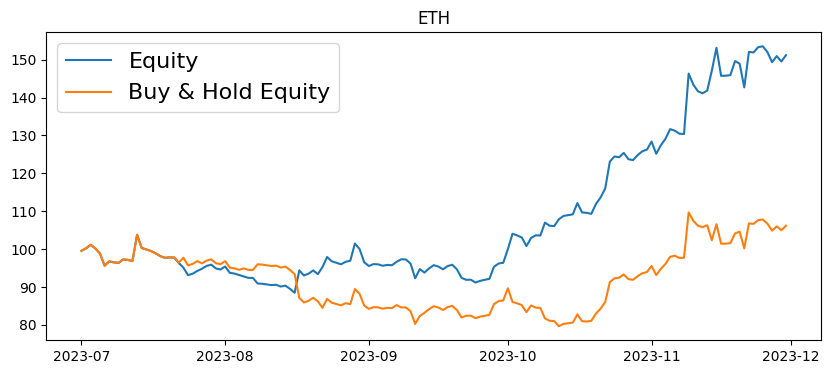

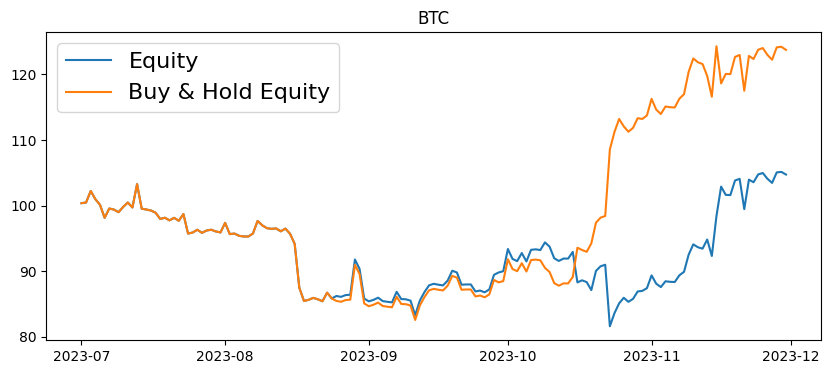

In [28]:
def equity():

    ETH_returns, ETH_equity, ETH_buy_and_hold = backtest(ETH, signals_ETH)
    ETH_sharp = sharp_ratio(ETH_returns)

    BTC_returns, BTC_equity, BTC_buy_and_hold = backtest(BTC, signals_BTC)
    BTC_sharp = sharp_ratio(BTC_returns)

    print(f"ETH Sharp Ratio : {ETH_sharp}")
    print(f"BTC Sharp Ratio : {BTC_sharp}")
    

    # mse_garch_eth = mean_squared_error(ETH, ETH_equity)
    # mse_garch_btc = mean_squared_error(BTC, BTC_equity)

    # print(f"MSE (GARCH - ETH): {mse_garch_eth:.7f}")
    # print(f"MSE (GARCH - BTC): {mse_garch_btc:.7f}")


    # def mean_absolute_percentage_error(y_true, y_pred):
    #     y_true, y_pred = np.array(y_true), np.array(y_pred)
    #     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # mape_garch_eth = mean_absolute_percentage_error(ETH, ETH_equity)
    # mape_garch_btc = mean_absolute_percentage_error(BTC, BTC_equity)

    # print(f"MAPE (GARCH - ETH): {mape_garch_eth:.7f}%")
    # print(f"MAPE (GARCH - BTC): {mape_garch_btc:.7f}%")

    print(f"ETH profit : {(ETH_equity.iloc[-1] - ETH_equity.iloc[0]) / ETH_equity.iloc[0] * 100}%")
    print(f"BTC profit : {(BTC_equity.iloc[-1] - BTC_equity.iloc[0]) / BTC_equity.iloc[0] * 100}%")

    plt.figure(figsize=(10,4))

    plt.title("ETH")
    plt.plot(ETH_equity)
    plt.plot(ETH_buy_and_hold)

    plt.legend(('Equity','Buy & Hold Equity'), fontsize=16)

    plt.figure(figsize=(10,4))

    plt.title("BTC")
    plt.plot(BTC_equity)
    plt.plot(BTC_buy_and_hold)

    plt.legend(('Equity','Buy & Hold Equity'), fontsize=16)

    

equity()